In [28]:
import tensorflow_datasets as tfds


def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, image  # Use the image itself as the target label

def map_func(sample):
    image = sample['image']
    label = sample['label']
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label


# Corrected file path with escaped backslashes and a missing comma
ds1, ds2, ds3 = tfds.load('patch_camelyon',
                         split=['train[:20%]', 'test[:5%]', 'validation[:5%]'],
                         data_dir=r'C:\Users\jeppe\OneDrive\Dokumenter\Privat\SDU\DataScience\Anvendtmaskinlæring\eksamen',
                         download=False,
                         shuffle_files=True)

train_dataset       = ds1.map(convert_sample).batch(32)
validation_dataset  = ds3.map(convert_sample).batch(32)
test_dataset        = ds2.map(convert_sample).batch(32)

train_dataset_cnn       = ds1.map(map_func).batch(32)
validation_dataset_cnn  = ds3.map(map_func).batch(32)
test_dataset_cnn        = ds2.map(map_func).batch(32)


In [47]:

import tensorflow.compat.v1 as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import MeanSquaredError

# Define the encoder part
class Encoder(tf.keras.layers.Layer): #initialiserer encoderen, definerer lagene og præciserer hvordan vores model skal konstrueres
    def __init__(self, latent_dim): 
        super(Encoder, self).__init__()
        self.conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')
        self.maxpool1 = layers.MaxPooling2D((2, 2), padding='same')
        self.conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.maxpool2 = layers.MaxPooling2D((2, 2), padding='same')
        self.flatten = layers.Flatten()
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)

    def call(self, x): #den faktiske model der forward pass'er data og transformerer det på baggrund af hvad der er defineret i def _init_
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        mean = self.dense_mean(x)
        log_var = self.dense_log_var(x)
        return mean, log_var

# Define the decoder part
class Decoder(tf.keras.layers.Layer):
    def __init__(self, latent_dim, original_shape):
        super(Decoder, self).__init__()
        self.dense = layers.Dense(units=original_shape[0] * original_shape[1] * original_shape[2], activation=tf.nn.relu)
        self.reshape = layers.Reshape(target_shape=(original_shape[0], original_shape[1], original_shape[2]))
        self.conv2dtranspose1 = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')
        self.conv2dtranspose2 = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')
        self.conv2dtranspose3 = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')

    def call(self, z):
        z = self.dense(z)
        z = self.reshape(z)
        z = self.conv2dtranspose1(z)
        z = self.conv2dtranspose2(z)
        reconstructed = self.conv2dtranspose3(z)
        return reconstructed

# Define the Variational Autoencoder as a whole
class VAE(Model):
    def __init__(self, latent_dim, original_shape):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim, original_shape)

    def sample(self, mean, log_var):
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon

    def call(self, x):
        mean, log_var = self.encoder(x)
        z = self.sample(mean, log_var)
        reconstructed = self.decoder(z)
        return reconstructed

# Set the latent dimension and original image shape
latent_dim = 128
original_shape = (96, 96, 3)  # Assuming PCAM images are of shape 96x96x3

# Instantiate the VAE
vae = VAE(latent_dim, original_shape)

# Compile the model
vae.compile(optimizer='adam', loss=MeanSquaredError())

# Freeze the layers in the encoder
vae.encoder.conv1.trainable = False
vae.encoder.maxpool1.trainable = False
vae.encoder.conv2.trainable = False
vae.encoder.maxpool2.trainable = False
vae.encoder.flatten.trainable = False
vae.encoder.dense_mean.trainable = False
vae.encoder.dense_log_var.trainable = False


vae.fit(
        train_dataset,
        epochs=10,  # You can adjust the number of epochs
        validation_data=validation_dataset
)

# Evaluate performance (you may use a validation set or a separate test set)
loss = vae.evaluate(test_dataset, verbose=1)


# Access the training history
loss = history.history['loss']
val_loss = history.history['val_loss']


Epoch 1/10
820/820 [==============================] - 266s 322ms/step - loss: 0.0353 - val_loss: 0.0338
Epoch 2/10
651/820 [======================>.......] - ETA: 1:10 - loss: 0.0294

In [44]:
def build_cnn(vae, latent_dim):
    # Create a new input layer that matches the original input
    cnn_input = layers.Input(shape=original_shape)

    # Get the mean vector from the encoder
    mean, _ = vae.encoder(cnn_input)

    # Build CNN layers for classification
    x = Dense(128, activation='relu')(mean)  # Processing the mean vector
    x = Dense(64, activation="relu")(x)
    
    cnn_output = Dense(2, activation="softmax")(x)  # Output layer for 2 classes

    # Create model
    cnn_model = Model(inputs=cnn_input, outputs=cnn_output)
    
    return cnn_model

In [45]:

# Build and compile the CNN model
cnn_model = build_cnn(vae, latent_dim)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the CNN model
history = cnn_model.fit(
    train_dataset_cnn,  # Your training dataset
    epochs=10,          # Adjust the number of epochs as needed
    validation_data=validation_dataset_cnn  # Your validation dataset
)

Epoch 1/10
820/820 [==============================] - 18s 22ms/step - loss: 19.4334 - accuracy: 0.5746 - val_loss: 1.6102 - val_accuracy: 0.6276
Epoch 2/10
820/820 [==============================] - 20s 24ms/step - loss: 1.0591 - accuracy: 0.6033 - val_loss: 0.9823 - val_accuracy: 0.6386
Epoch 3/10
820/820 [==============================] - 19s 23ms/step - loss: 0.7302 - accuracy: 0.6214 - val_loss: 0.9353 - val_accuracy: 0.6435
Epoch 4/10
820/820 [==============================] - 16s 20ms/step - loss: 0.6494 - accuracy: 0.6352 - val_loss: 0.9324 - val_accuracy: 0.6349
Epoch 5/10
820/820 [==============================] - 16s 20ms/step - loss: 0.6239 - accuracy: 0.6515 - val_loss: 0.8007 - val_accuracy: 0.6374
Epoch 6/10
820/820 [==============================] - 16s 20ms/step - loss: 0.6017 - accuracy: 0.6688 - val_loss: 0.8097 - val_accuracy: 0.6777
Epoch 7/10
820/820 [==============================] - 17s 20ms/step - loss: 0.5971 - accuracy: 0.6786 - val_loss: 0.7450 - val_accuracy

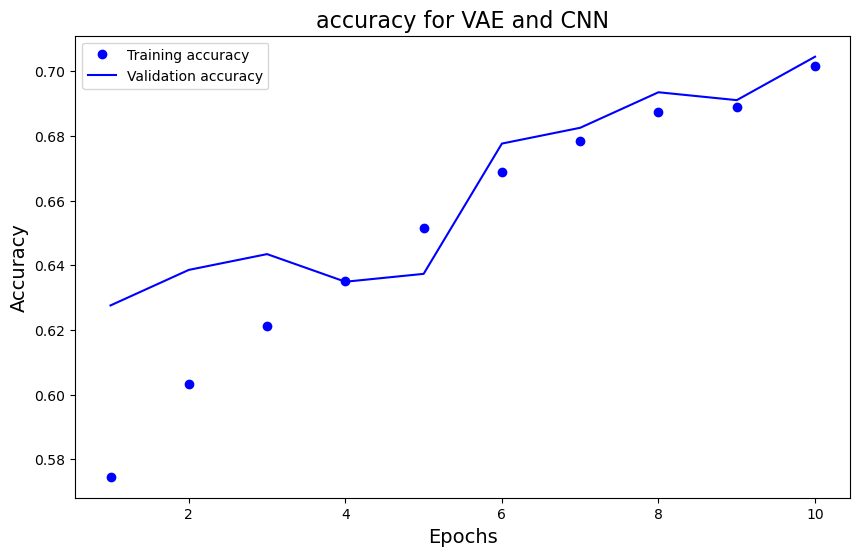

In [46]:
#plotter CNN accuracy

import matplotlib.pyplot as plt

# Access the history of training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Access the epochs range
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')

# Add a title with a specified fontsize
plt.title('accuracy for VAE and CNN', fontsize=16)

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()

plt.show()

